In [1]:
from QVM import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
#HeatMap from https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/hardware/qubit_picking.ipynb#scrollTo=WLfGbpVIune1

# Choose a processor ("rainbow" or "weber")
processor_id = "rainbow"
# Load the median device noise calibration for your selected processor.
cal = cirq_google.engine.load_median_device_calibration(processor_id)
# Create the noise properties object.
noise_props = cirq_google.noise_properties_from_calibration(cal)
# Create a noise model from the noise properties.
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
# Prepare a qsim simulator using the noise model.
sim = qsimcirq.QSimSimulator(noise=noise_model)

# Package the simulator and device in an Engine.
# The device object
device = cirq_google.engine.create_device_from_processor_id(processor_id)
# The simulated processor object
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id, sampler=sim, device=device, calibrations={cal.timestamp // 1000: cal}
)
# The virtual engine
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])
print(
    "Your quantum virtual machine",
    processor_id,
    "is ready, here is the qubit grid:",
    "\n========================\n",
)
print(sim_engine.get_processor(processor_id).get_device())

Your quantum virtual machine rainbow is ready, here is the qubit grid: 

                  (3, 2)
                  │
                  │
         (4, 1)───(4, 2)───(4, 3)
         │        │        │
         │        │        │
(5, 0)───(5, 1)───(5, 2)───(5, 3)───(5, 4)
         │        │        │        │
         │        │        │        │
         (6, 1)───(6, 2)───(6, 3)───(6, 4)───(6, 5)
                  │        │        │        │
                  │        │        │        │
                  (7, 2)───(7, 3)───(7, 4)───(7, 5)───(7, 6)
                           │        │        │
                           │        │        │
                           (8, 3)───(8, 4)───(8, 5)
                                    │
                                    │
                                    (9, 4)


### One qubit gate Pauli error data

Pauli error defines decoherence of a single qubit in one of the Pauli [channels](/cirq/noise/representing_noise) X, Y, or Z. If the errors are distributed in the uniform distribution over all three axes, the probability of applying an erroneous Pauli gate X, Y, or Z will be the Pauli error divided by three. See page 11 of [this Supplementary Information document](https://arxiv.org/abs/1910.11333){:.external} for more on Pauli error. 

Below is the single qubit Pauli error for the `cirq.PhasedXZGate` supported by the Rainbow processor, pulled from the `gate_pauli_errors` attribute of the noise properties object. You can inspect the error for the other supported one-qubit gates by replacing the `gate` variable below. However, as of July 19th, 2022, the error estimation process results in identical Pauli error for all one-qubit gates.


One qubit error data: gate_pauli_errors
Supported Gates: {<class 'cirq.ops.common_channels.ResetChannel'>, <class 'cirq.ops.measurement_gate.MeasurementGate'>, <class 'cirq.ops.phased_x_z_gate.PhasedXZGate'>, <class 'cirq.ops.common_gates.ZPowGate'>}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/var/folders/n1/pnl56x2517d3_ydprywsnrn40000gn/T/ipykernel_80276/2537401730.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


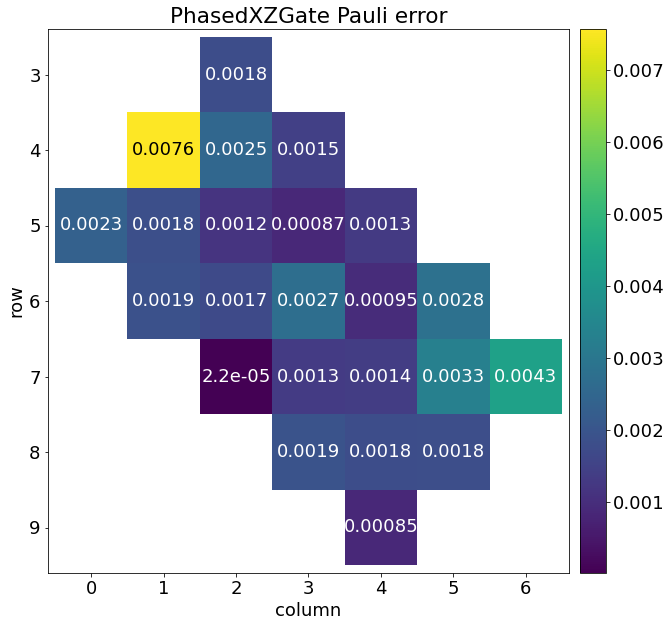

In [3]:
print(f"One qubit error data: gate_pauli_errors")
print(f"Supported Gates: {noise_props.single_qubit_gates()}")
fig, ax = plt.subplots(figsize=(10, 10))
gate = cirq.PhasedXZGate
measures = {
    op_id.qubits: pauli_error
    for op_id, pauli_error in noise_props.gate_pauli_errors.items()
    if op_id.gate_type == gate
}
ax.set_title(f"{gate.__name__} Pauli error")
_ = cirq.Heatmap(measures).plot(ax)
fig.savefig(f"{gate.__name__}_Pauli_error_"+processor_id+".png")
fig.show()

The provided error data shows identical Pauli error for all gate types, with relatively higher error for qubits `(4,1)` and `(7,6)`. Qubit `(7,2)` is noticeably lower error than the others, and could be prioritized to be mapped to a circuit qubit that executes many single-qubit operations. However, this is only one type of error; you should inspect the other error types before committing to use any particular qubits.


### Two qubit gate Pauli error data

The two qubit gates also cause Pauli decoherence, which is also stored in the `gate_pauli_errors` attribute. 

Two qubit error data: gate_pauli_errors


/var/folders/n1/pnl56x2517d3_ydprywsnrn40000gn/T/ipykernel_80276/2320950721.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


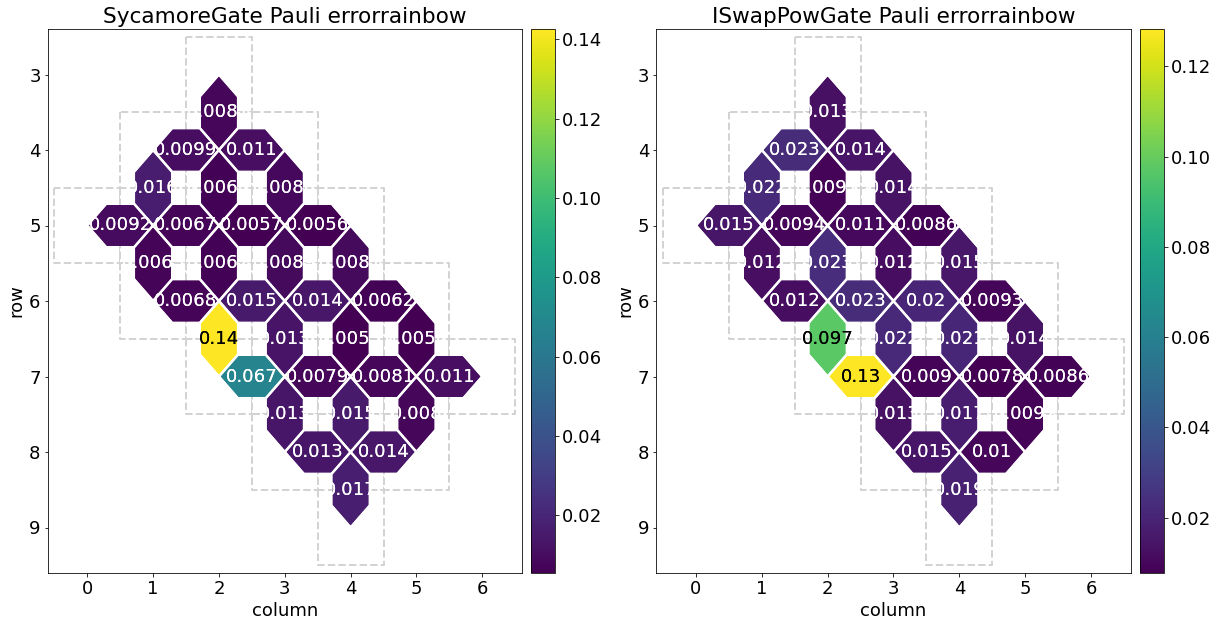

In [4]:
two_qubit_gates = noise_props.two_qubit_gates()
print(f"Two qubit error data: gate_pauli_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        ax.set_title(f"{gate.__name__} Pauli error"+processor_id)
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)
fig.savefig(f"{gate.__name__} Pauli error_"+processor_id+".png")
fig.show()

This Pauli data informs that the qubit pairs `(6,2)-(7,2)` and `(7,2)-(7,3)` should be avoided at all costs, but the other qubits are roughly comparable.

### Two qubit gate FSim error

FSim error represents [coherent](/cirq/noise/representing_noise#channels) two-qubit error that cannot be represented by Pauli channels (that is, it results from entanglement). Instead, it is represented as an additional `cirq.PhasedFSimGate` with small parameters that would be applied to a given qubit pair after any two-qubit gate's execution.

The following example takes the norm of a couple of the parameters, as a rough approximate representation of the goodness of qubit pairs relative to one another. 

Two qubit error data: fsim_errors


/var/folders/n1/pnl56x2517d3_ydprywsnrn40000gn/T/ipykernel_80276/1692522453.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


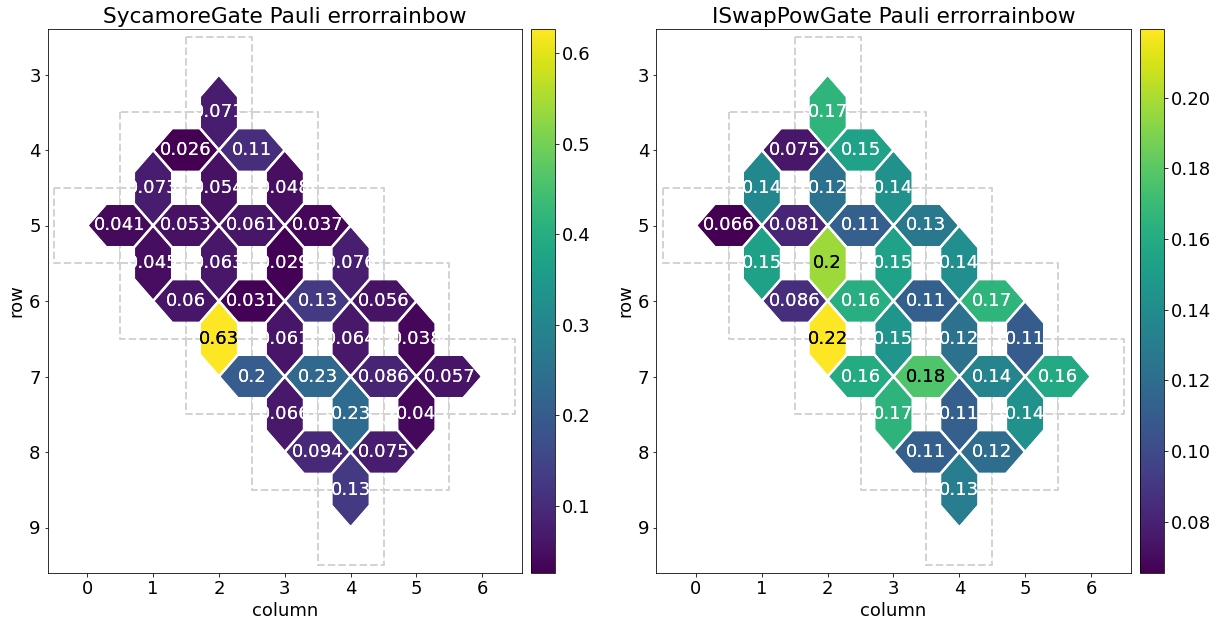

In [5]:
print(f"Two qubit error data: fsim_errors")
two_qubit_gates = noise_props.two_qubit_gates()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: fsim_refit_gate
        for op_id, fsim_refit_gate in noise_props.fsim_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        # Norm the Fsim refit gate parameters as an approximate of how good a qubit is.
        measures = {
            qubits: np.linalg.norm([fsim_refit_gate.theta, fsim_refit_gate.phi])
            for qubits, fsim_refit_gate in measures.items()
        }
        ax.set_title(f"{gate.__name__} Pauli error"+processor_id)
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)
fig.savefig(f"{gate.__name__} Pauli error_FSIM_"+processor_id+".png")
fig.show()

This fsim data would influence you to avoid the `(6,2)-(7,2)` qubit pair, and prefer the top left of the grid for high-priority qubit pairs  (those that have two-qubit gates executed on them many times in your circuit). Additionally, the fact that the `cirq.SycamoreGate` error is so much lower than the `cirq.ISwapPowGate` error means the device was likely calibrated for the `SycamoreGate`, and you should [transform](/cirq/transform/transformers) your circuit with `cirq.optimize_for_target_gateset` to the `cirq_google.transformers.SycamoreTargetGateset` gate set, if possible.

This particular type of error can be compensated for somewhat, by using [Floquet calibration](/cirq/noise/floquet_calibration_example), but this is out of scope for this notebook, and may require adaptation to work with the provided processor error data.

### Readout error

Readout error manifests as a measurement of $|0\rangle$ that should have been $|1\rangle$, or vice versa. Note that this is different from the Pauli error induced by the `cirq.MeasurementGate`. It's important to note that, while the magnitude of measurement error is higher in general than that of Pauli error, it should be not automatically be considered to be more impactful. This is due to the fact that Pauli error can affect qubits other than the measured one and that effective readout error compensation strategies exist (that won't be discussed here).

One qubit error data: readout_errors


/var/folders/n1/pnl56x2517d3_ydprywsnrn40000gn/T/ipykernel_80276/2124637126.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


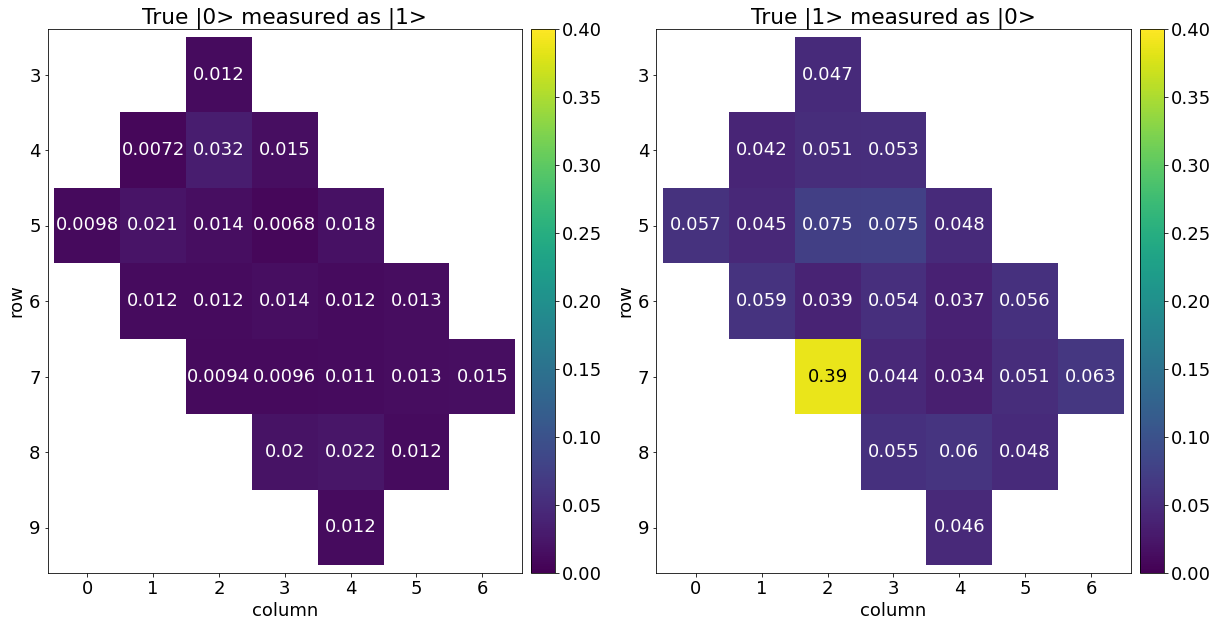

In [6]:
print(f"One qubit error data: readout_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, ax, title in zip(
    range(2), axes.flat, ["True |0> measured as |1>", "True |1> measured as |0>"]
):
    measures = {
        qubit: readout_error[i] for qubit, readout_error in noise_props.readout_errors.items()
    }
    ax.set_title(title)
    _ = cirq.Heatmap(measures).plot(ax, vmax=0.4, vmin=0)
fig.savefig("Readout_error_"+processor_id+".png")
fig.show()

This readout data indicates that you definitely want to avoid qubit `(7,2)`. If you're really trying to eke out the best performance possible, you may want to avoid qubits `(5,2)` and `(5,3)` as well. Note how the "True $|1\rangle$ measured as $|0\rangle$" error representing common decay is far larger and more impactful than the random excitation of $|0\rangle$ to $|1\rangle$ error. This is typical behavior and you can safely prioritize working around common decay error instead of random excitation error in most cases.

## Overall qubit picking strategy

Even though the single Pauli qubit data preferred qubit `(7,2)`, the coupled pairs attached to that qubit have abysmal error rates, meaning it should be avoided at all costs. Qubit `(4,1)` has some interesting properties in that its two-qubit gates are quite good, and so is its readout, but not its single-qubit Pauli error. It may be useful to use this qubit in an entangled system where only the other qubits have single-qubit gates applied to them. All of the other gates are roughly comparable based on these error rates. Ultimately, the choice of which hardware qubits have which circuit operations applied to them is up to your discretion.

100%|██████████| 1500/1500 [06:59<00:00,  3.58it/s]


obs rho: (0.9535200000000001+0j)
obs rho2: (0.8832723482185634-1.146729144235518e-20j)
obs rho3: (0.9897108413519111-4.165796876973282e-19j)
obs rho: (0.77616+0j)
obs rho2: (0.8620555593631073-7.147143237264615e-20j)
obs rho3: (0.9818067730811402-2.956465150069508e-19j)
obs rho: (0.8287199999999999+0j)
obs rho2: (0.8714791167830767-2.0703333727711919e-19j)
obs rho3: (0.9787234740543103+1.2438502510569864e-18j)
obs rho: (0.8649600000000001+0j)
obs rho2: (0.8702037553113167-1.6717187936051712e-20j)
obs rho3: (0.9841007036231058+2.3280100354232334e-19j)
obs rho: (0.57672-3.469446951953614e-18j)
obs rho2: (0.7113377463387156+1.3699866662466642e-34j)
obs rho3: (0.88355915074419-6.938893903907235e-18j)


100%|██████████| 1500/1500 [09:58<00:00,  2.51it/s]


obs rho: (0.73224+0j)
obs rho2: (0.8363436281526202+2.99680958155452e-19j)
obs rho3: (0.9853787156880156-1.0218332064417278e-18j)
obs rho: (0.73152+0j)
obs rho2: (0.87934033294753+1.9762254975022766e-19j)
obs rho3: (0.9852842579970418-8.112575849482584e-19j)
obs rho: (0.84192+0j)
obs rho2: (0.8337034941522916+3.500926620369885e-19j)
obs rho3: (0.9838831098952401-7.22937938068482e-19j)
obs rho: (0.7725599999999999+0j)
obs rho2: (0.8461136977821497+2.7945082843346473e-19j)
obs rho3: (0.9853537705740376-1.0043672851211585e-18j)
obs rho: (0.39528-1.3877787807814457e-17j)
obs rho2: (0.7844024562087529-2.7755575615628907e-17j)
obs rho3: (0.9374392000245608+0j)


100%|██████████| 1500/1500 [08:17<00:00,  3.02it/s]


obs rho: (0.84744+0j)
obs rho2: (0.8890036506501449-1.980089979959369e-19j)
obs rho3: (0.9933730674982024+5.395122284979058e-20j)
obs rho: (0.7454400000000001+0j)
obs rho2: (0.8867404416800387-1.5061729722611684e-19j)
obs rho3: (0.9898149441674613-1.1666067174256604e-19j)
obs rho: (0.7444799999999999+0j)
obs rho2: (0.8867730992718281-1.204112837463656e-19j)
obs rho3: (0.9877217158701211-8.158839242851484e-20j)
obs rho: (0.8519999999999999+0j)
obs rho2: (0.9061762879735504-1.1896693195694023e-19j)
obs rho3: (0.9924653650686439+2.331445885805914e-20j)
obs rho: (1.0044+1.3877787807814457e-17j)
obs rho2: (0.8578903133280871+2.0816681711721685e-17j)
obs rho3: (0.9567318233546642+4.8572257327350623e-17j)


100%|██████████| 1500/1500 [10:26<00:00,  2.39it/s]


obs rho: (0.88632+0j)
obs rho2: (0.8890502059898866-8.102434098653276e-20j)
obs rho3: (0.9937288382573359+2.8162470890208464e-20j)
obs rho: (0.8455199999999998+0j)
obs rho2: (0.8910140742433228-1.627259690482718e-19j)
obs rho3: (0.9913584028802921+1.943591901988227e-19j)
obs rho: (0.74016+0j)
obs rho2: (0.8896666069979624-1.155411002791644e-19j)
obs rho3: (0.9863843324295379-7.491859839453227e-21j)
obs rho: (0.75072+0j)
obs rho2: (0.8615983189668808-2.693533087337918e-19j)
obs rho3: (0.9844081927109217+5.836427373883214e-19j)
obs rho: (0.76464-6.938893903907228e-18j)
obs rho2: (0.8259973164104981+6.938893903907228e-18j)
obs rho3: (0.9487866930923881+2.9236747249004364e-33j)
{'ZZIII0': [(0.9535200000000001+0j), (0.73224+0j), (0.84744+0j), (0.88632+0j)], 'ZZIII1': [(0.8832723482185634-1.146729144235518e-20j), (0.8363436281526202+2.99680958155452e-19j), (0.8890036506501449-1.980089979959369e-19j), (0.8890502059898866-8.102434098653276e-20j)], 'ZZIII2': [(0.9897108413519111-4.1657968769732

/Users/yanislefur/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/yanislefur/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/yanislefur/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/yanislefur/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/yanislefur/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/yanislefur/opt/anaconda3/lib/py

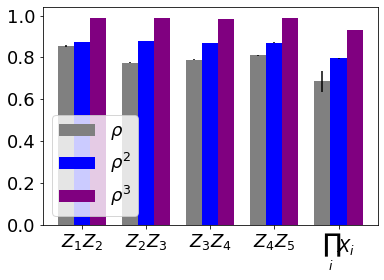

In [2]:
N=5
qubits = cirq.LineQubit.range(N)
ghz_circuit = base(qubits)
processor_id = "rainbow"


'''#Weber config
device_qubit_chain=[
cirq.GridQubit(4, 1),
cirq.GridQubit(4, 2),
cirq.GridQubit(4, 3),
cirq.GridQubit(4, 4),
cirq.GridQubit(4, 5),
]
'''
#Rainbow config
device_qubit_chain=[
cirq.GridQubit(5, 0),
cirq.GridQubit(5, 1),
cirq.GridQubit(5, 2),
cirq.GridQubit(5, 3),
cirq.GridQubit(5, 4),
]

N_U = 1500
N_S = 50
n_average = 4
observables = ["ZZIII","IZZII","IIZZI","IIIZZ","XXXXX"]
delta = {}
gate_type = cirq_google.transformers.SycamoreTargetGateset() #cirq.SqrtIswapTargetGateset()


for obs in observables:
     for i in range(3):
          delta[obs+str(i)]=[]


for _ in range(n_average):
    rho_shadow = find_rho_N_U(ghz_circuit,qubits,device_qubit_chain,processor_id,gate_type,N,N_U,N_S)
    rho_shadow2 = rho_shadow@rho_shadow
    rho_shadow3 = rho_shadow2@rho_shadow
    rho_shadow/=np.trace(rho_shadow)
    rho_shadow2/=np.trace(rho_shadow2)
    rho_shadow3/=np.trace(rho_shadow3)
    for obs in observables:
        O = 1.
        for o in obs:

            O = np.kron(obs_gate(o),O)
        print("obs rho:",np.trace(rho_shadow@O)/np.trace(rho_shadow))
        print("obs rho2:",np.trace(rho_shadow2@O)/np.trace(rho_shadow2))
        print("obs rho3:",np.trace(rho_shadow3@O)/np.trace(rho_shadow3))
        delta[obs+str(0)].append(np.trace(rho_shadow@O)/np.trace(rho_shadow))
        delta[obs+str(1)].append(np.trace(rho_shadow2@O)/np.trace(rho_shadow2))
        delta[obs+str(2)].append(np.trace(rho_shadow3@O)/np.trace(rho_shadow3))

print(delta)
with open('delta.txt', 'w') as f:
    print(delta, file=f)

x1 = []
x2 = []
x3 = []
err_x1 = []
err_x2 = []
err_x3 = []
for obs in observables:
    for i in range(3):
        print("Mean"+obs+str(i)+": ",np.mean(delta[obs+str(i)]),"var"+obs+str(i)+": ",np.var(delta[obs+str(i)]))
    x1.append(np.mean(delta[obs+str(0)]))
    x2.append(np.mean(delta[obs+str(1)]))
    x3.append(np.mean(delta[obs+str(2)]))
    err_x1.append(np.var(delta[obs+str(0)]))
    err_x2.append(np.var(delta[obs+str(1)]))
    err_x3.append(np.var(delta[obs+str(2)]))

  
etiquette = [r'$Z_1Z_2$',r'$Z_2Z_3$',r'$Z_3Z_4$',r'$Z_4Z_5$',r'$\prod_i X_i$']
position = np.arange(len(etiquette))
largeur = .25

fig, ax = plt.subplots()
r1 = ax.bar(position - largeur, x1,yerr = err_x1,width =  largeur,color = "grey",label = r'$\rho$')
r2 = ax.bar(position , x2, yerr = err_x2,width = largeur,color = "blue",label = r'$\rho^2$')
r3 = ax.bar(position + largeur, x3,yerr = err_x3,width = largeur,color = "purple",label = r'$\rho^3$')
ax.set_xticks(position)
ax.set_xticklabels(etiquette)
plt.legend(loc='lower left')
plt.savefig("QVM_mean_var_N_U="+str(N_U)+"_N_S="+str(N_S)+"_"+processor_id+"_Sycamore.png")
plt.show()



